In [49]:
#assumptions that will break if we use MCTS for play traces in this code
#1. Turn wont be either 0 or 1
#2. Cant just copy the final two rows to extend round number to maxNoOfRounds

In [50]:
import pandas as pd
import pdb
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
#from sklearn.manifold import MDS 
from sklearn.cluster import KMeans
import itertools
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)

In [51]:
#parameters for round robin tournament
NOOFPLAYERS = 2 #note, keep this fixed and dont change it - we always assume there are only two players
games_per_matchup = 100
self_play = False
agents = ['MCTS_A_Budget_1000', 'MCTS_B_Budget_1000']

NoOfGames = 2 * games_per_matchup
if self_play == True:
    NoOfGames = 4 * games_per_matchup

In [52]:
data  = pd.read_csv("data/featureslogfile_Budget_2000_Budget_2000_GPM_100_NoSelfPlay.txt", sep = '\t')
print(data)
print(data.columns)

       GameID  Player  Round  Turn  CurrentScore  SCORE  SCORE_ADV  ORDINAL  \
0         2.0     0.0    0.0   0.0           3.0   0.06       0.00      0.5   
1         2.0     1.0    0.0   0.0           3.0   0.06       0.00      0.5   
2         2.0     0.0    0.0   1.0           3.0   0.06       0.00      0.5   
3         2.0     1.0    0.0   1.0           3.0   0.06       0.00      0.5   
4         2.0     0.0    1.0   0.0           3.0   0.06       0.00      0.5   
...       ...     ...    ...   ...           ...    ...        ...      ...   
23233   201.0     1.0   21.0   1.0          49.0   0.98      -0.12      1.0   
23234   201.0     0.0   22.0   0.0          53.0   1.06       0.16      0.5   
23235   201.0     1.0   22.0   0.0          49.0   0.98      -0.16      1.0   
23236   201.0     0.0   22.0   1.0          53.0   1.06      -0.16      1.0   
23237   201.0     1.0   22.0   1.0          57.0   1.14       0.16      0.5   

       OUR_TURN  HAS_WON  ...  MINE  SENTRY  WITCH 

In [53]:
#label all games with corresponding agent names

#first generate match-ups
matchups = []
if self_play:
    for agent1 in agents:
        for agent2 in agents:
            matchups.append((agent1, agent2))
else:
    matchups = list(itertools.permutations(agents, 2))
    
#function to map gameID to match-up
def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
    game_group = int((game_id - min_game_id)/no_games_per_matchup)
    matchup = matchup_list[game_group]
    agent1, agent2 = matchup
    if player_no == 0:
        return agent1
    else:
        return agent2
        
#add agent names to data set
min_GameID = data['GameID'].min()
data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)                         

In [54]:
#check for agmes where the round number suddenly decreases (Bug in TAG? - nope this was
#from me stopping execution and restarting and the code appending results to an existing file)
NoGamesDropped = 0 
for game in data['GameID'].unique():
    round_data = data[data['GameID'] == game]['Round']
    round_delta = round_data - round_data.shift(1)
    if round_delta.min() < 0:
        NoGamesDropped += 1
        print("Issue with GameID: " + str(game))

In [55]:
#define columns of interest 
#card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY', 'THRONE_ROOM', 'WITCH',
                 'WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types = card_types_SD 
cols = ['AgentName', 'Player', 'GameID', 'Round', 'CurrentScore']
cols = cols + card_types

In [56]:
#we seem to have an issue with some cards having their number reduced, which shouldn't happen in a BMWG vs DW set-up
#for card in card_types_BigMoneyWithGardens_vs_DoubleWitch:
#    for game in data['GameID'].unique():
#        for player in data['Player'].unique():
#            card_evol = data[(data['GameID'] == game) & (data['Player'] == player) & (data['Turn'] == 1)][card]
#            card_delta = card_evol - card_evol.shift(1)
#            if card_delta.min() < 0:
#                print("Issue with " + str(card) + " in game " + str(game) + " with player " + str(player))
                
#problem_trace = data[(data['GameID'] == 27) & (data['Player'] == 1)]['WITCH']
#print(problem_trace)

In [57]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
print(data['Turn'].unique())
data = data[data['Turn'] == 1]

[0. 1.]


In [58]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

                AgentName  Player  GameID  Round  CurrentScore  ARTISAN  \
2      MCTS_A_Budget_1000     0.0     2.0    0.0           3.0      0.0   
3      MCTS_B_Budget_1000     1.0     2.0    0.0           3.0      0.0   
6      MCTS_A_Budget_1000     0.0     2.0    1.0           3.0      0.0   
7      MCTS_B_Budget_1000     1.0     2.0    1.0           3.0      0.0   
10     MCTS_A_Budget_1000     0.0     2.0    2.0           3.0      0.0   
...                   ...     ...     ...    ...           ...      ...   
23229  MCTS_A_Budget_1000     1.0   201.0   20.0          49.0      0.0   
23232  MCTS_B_Budget_1000     0.0   201.0   21.0          52.0      0.0   
23233  MCTS_A_Budget_1000     1.0   201.0   21.0          49.0      0.0   
23236  MCTS_B_Budget_1000     0.0   201.0   22.0          53.0      0.0   
23237  MCTS_A_Budget_1000     1.0   201.0   22.0          57.0      0.0   

       BANDIT  BUREAUCRAT  CHAPEL  FESTIVAL  ...  THRONE_ROOM  WITCH  \
2         0.0         0.0  

In [59]:
#we need to make sure all games have the same number of rounds in them
gameLengths = traces.groupby(['GameID'])['Round'].max()
maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
print(maxNoOfRounds)

62


In [60]:
def copy_final_deck_at_game_end(group, roundMax, noPlayers):
    #This function repeatedly copies the final decks of two players at the game end, so that the game is extended to 
    #have roundMax rounds
    final_round = int(group['Round'].max())
    if (roundMax-1) == final_round:
        #in this case we dont need to extend the play trace
        return group
    else:
        final_row_copy = pd.concat([group.iloc[-noPlayers:]] * ((roundMax-1) - final_round), ignore_index=True)
        #we need to update the Round counter so that every other row it increments by one
        final_row_copy['Round'] = [final_round + 1 + i // 2 for i in range(((roundMax-1) - final_round)*2)]
        return pd.concat([group, final_row_copy], ignore_index=True)

In [61]:
extended_traces = traces.groupby('GameID').apply(copy_final_deck_at_game_end, maxNoOfRounds, NOOFPLAYERS).reset_index(drop = True)
print(extended_traces)
print("Expected no rows: " + str(maxNoOfRounds*NOOFPLAYERS*(NoOfGames-NoGamesDropped)))
print("Expected no of cols: " + str(len(card_types)+5))
print(extended_traces.shape)

                AgentName  Player  GameID  Round  CurrentScore  ARTISAN  \
0      MCTS_A_Budget_1000     0.0     2.0    0.0           3.0      0.0   
1      MCTS_B_Budget_1000     1.0     2.0    0.0           3.0      0.0   
2      MCTS_A_Budget_1000     0.0     2.0    1.0           3.0      0.0   
3      MCTS_B_Budget_1000     1.0     2.0    1.0           3.0      0.0   
4      MCTS_A_Budget_1000     0.0     2.0    2.0           3.0      0.0   
...                   ...     ...     ...    ...           ...      ...   
24795  MCTS_A_Budget_1000     1.0   201.0   59.0          57.0      0.0   
24796  MCTS_B_Budget_1000     0.0   201.0   60.0          53.0      0.0   
24797  MCTS_A_Budget_1000     1.0   201.0   60.0          57.0      0.0   
24798  MCTS_B_Budget_1000     0.0   201.0   61.0          53.0      0.0   
24799  MCTS_A_Budget_1000     1.0   201.0   61.0          57.0      0.0   

       BANDIT  BUREAUCRAT  CHAPEL  FESTIVAL  ...  THRONE_ROOM  WITCH  \
0         0.0         0.0  

In [62]:
#next we need to flatten this dataframe so that each trace is a single row.
#Note we drop the current score as we dont need it for now. We also drop the round label as it is redundant
#and it will get reintroduced when flattening through the revised column names
traces_tmp = extended_traces.drop(['CurrentScore', 'Round'], axis = 1)
cols = [card_types[i] + "_R" + str(r) 
        for r in range(0, maxNoOfRounds) for i in range(0, len(card_types))] 

extended_traces_flat = traces_tmp.groupby(['AgentName', 'Player', 'GameID']).apply(lambda df: df[card_types].values.flatten())
extended_traces_flat = pd.DataFrame(extended_traces_flat, columns = ['Trace']).reset_index()
extended_traces_flat = pd.concat([extended_traces_flat[['AgentName', 'Player', 'GameID']], extended_traces_flat['Trace'].apply(pd.Series)], axis=1)
extended_traces_flat.columns = ['AgentName', 'Player', 'GameID'] + cols

#note we also add the name of the agent of the opponent for each trace (this is used later when grouping play traces)
extended_traces_flat['Opponent'] = extended_traces_flat.apply(lambda row: 1.0 if row['Player'] == 0.0 else 0.0, axis = 1)
extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: gameID_to_matchup(row['GameID'], row['Opponent'], matchups, games_per_matchup, min_GameID), axis = 1)                                   

print(extended_traces_flat)

              AgentName  Player  GameID  ARTISAN_R0  BANDIT_R0  BUREAUCRAT_R0  \
0    MCTS_A_Budget_1000     0.0     2.0         0.0        0.0            0.0   
1    MCTS_A_Budget_1000     0.0     3.0         0.0        1.0            0.0   
2    MCTS_A_Budget_1000     0.0     4.0         0.0        0.0            0.0   
3    MCTS_A_Budget_1000     0.0     5.0         0.0        0.0            0.0   
4    MCTS_A_Budget_1000     0.0     6.0         0.0        1.0            0.0   
..                  ...     ...     ...         ...        ...            ...   
395  MCTS_B_Budget_1000     1.0    97.0         0.0        1.0            0.0   
396  MCTS_B_Budget_1000     1.0    98.0         0.0        0.0            0.0   
397  MCTS_B_Budget_1000     1.0    99.0         0.0        0.0            0.0   
398  MCTS_B_Budget_1000     1.0   100.0         0.0        0.0            0.0   
399  MCTS_B_Budget_1000     1.0   101.0         0.0        0.0            0.0   

     CHAPEL_R0  FESTIVAL_R0

In [63]:
#next we compute the average traces for each combination of players and opponents, this 
#allows us to compare to the centroids computed by k-means clustering (note this is only 
#useful when we know what strategies are being employed by our AI agents or players, and 
#is used to sense check K-means in our base case scenarios)

flat_trace_tmp = extended_traces_flat.drop(['Player','Opponent','GameID'], axis = 1)
average_traces = flat_trace_tmp.groupby(['AgentName','AgentNameOpponent']).apply(lambda row: round(row.mean())).reset_index()
new_col_names = {old_col: old_col + '_avg' for old_col in average_traces.columns[2:]}
average_traces.rename(columns = new_col_names, inplace = True)
print(average_traces)

            AgentName   AgentNameOpponent  ARTISAN_R0_avg  BANDIT_R0_avg  \
0  MCTS_A_Budget_1000  MCTS_B_Budget_1000             0.0            0.0   
1  MCTS_B_Budget_1000  MCTS_A_Budget_1000             0.0            0.0   

   BUREAUCRAT_R0_avg  CHAPEL_R0_avg  FESTIVAL_R0_avg  GARDENS_R0_avg  \
0                0.0            0.0              0.0             0.0   
1                0.0            0.0              0.0             0.0   

   SENTRY_R0_avg  THRONE_ROOM_R0_avg  ...  THRONE_ROOM_R61_avg  WITCH_R61_avg  \
0            0.0                 0.0  ...                  0.0            0.0   
1            0.0                 0.0  ...                  0.0            0.0   

   WORKSHOP_R61_avg  CURSE_R61_avg  PROVINCE_R61_avg  DUCHY_R61_avg  \
0               2.0            1.0               3.0            4.0   
1               2.0            1.0               3.0            4.0   

   ESTATE_R61_avg  GOLD_R61_avg  SILVER_R61_avg  COPPER_R61_avg  
0             6.0           4.

[1.         0.65086642 0.57364747 0.52129098 0.48533257 0.45774262
 0.43864656 0.42079859 0.40769364 0.39122746 0.38172254 0.37119461
 0.3590502  0.34886559 0.34076871 0.33531794 0.3276359  0.31785306
 0.31613875 0.31110478 0.30585005 0.30134004 0.29478912 0.29297167]


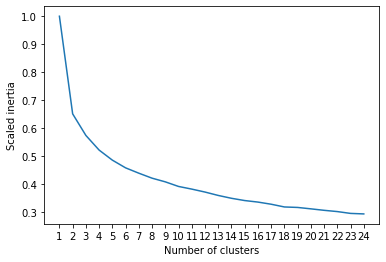

In [64]:
#inertia and elbow method
range_n_clusters = range(1, 25, 1)
inertia_vals = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    cluster_labels = clusterer.fit_predict(trace_X)
    inertia_vals.append(clusterer.inertia_)

#scale the inertia vals so that the first value is one
inertia_vals = np.array(inertia_vals)/inertia_vals[0]

#plot as a line plot
plt.plot(range_n_clusters, inertia_vals)
plt.xticks(range_n_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Scaled inertia")

#output inertia values
print(inertia_vals)

For n_clusters = 2 The average silhouette_score is : 0.31830514557130923
For n_clusters = 3 The average silhouette_score is : 0.26435331091230757
For n_clusters = 4 The average silhouette_score is : 0.15715112259584338
For n_clusters = 5 The average silhouette_score is : 0.15320261667390941
For n_clusters = 6 The average silhouette_score is : 0.1501146364262677


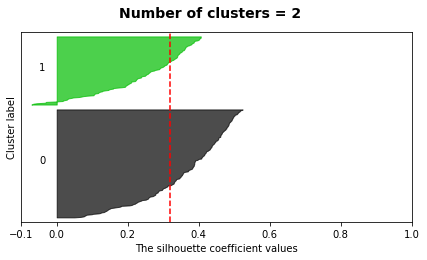

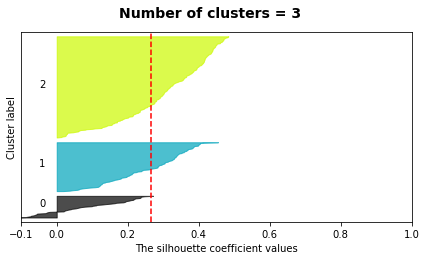

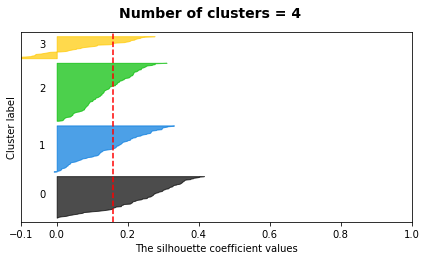

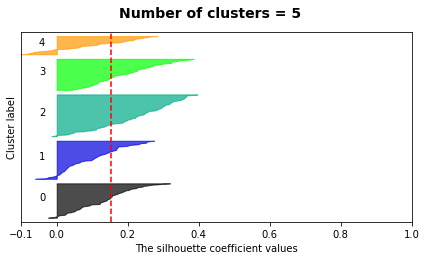

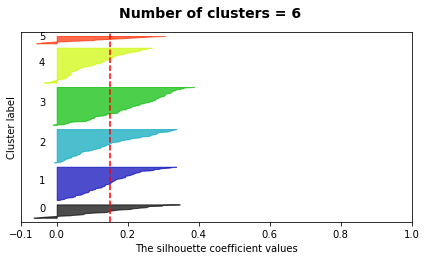

Text(0, 0.5, 'Silhouette Average')

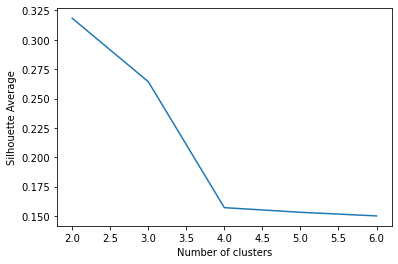

In [65]:
#next we consider three different methods for choosing the optimal number of clusters. If these dont perform well
#we will move onto the more complex approach of the gap statistic

#silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_list = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(7, 3.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(trace_X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    #cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.fit_predict(trace_X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(trace_X, cluster_labels)
    silhouette_avg_list.append(silhouette_avg)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(trace_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(
        #"Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        "Number of clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#also we plot just the average silhouette values by cluster number
plt.plot(range_n_clusters, silhouette_avg_list)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Average")

In [66]:
#next we want to apply k-means clustering with (euclidean distance measure) on our set of traces 
num_clusters = len(matchups)
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(trace_X)

In [67]:
#add kmeans cluster classifications of traces to dataframe and see how that aligns with AI agent strategies
extended_traces_flat['ClusterID'] = kmeans.labels_
strat_vs_clusterid = extended_traces_flat[['AgentName', 'AgentNameOpponent','ClusterID']]
counts = strat_vs_clusterid.groupby(['AgentName', 'AgentNameOpponent','ClusterID']).size()
print(counts)

AgentName           AgentNameOpponent   ClusterID
MCTS_A_Budget_1000  MCTS_B_Budget_1000  0             84
                                        1            116
MCTS_B_Budget_1000  MCTS_A_Budget_1000  0             71
                                        1            129
dtype: int64


In [68]:
def deck_evol_comparison(trace1, trace2, tag1, tag2, cardTypes, maxRounds, label1 = 'Trace1', label2 = 'Trace2'):
    #look at evolution of number of cards of each type per round
    noCardTypes = len(cardTypes)
    noOfSubplotsInXDirection = 4
    noOfSubplotsInYDirection = 5
    fig, axs = plt.subplots(noOfSubplotsInXDirection, noOfSubplotsInYDirection, figsize = (10,10))
    for i in range(0,noOfSubplotsInXDirection):
        for j in range(0,noOfSubplotsInYDirection):
            cardIndex = noOfSubplotsInXDirection*j + i
            if cardIndex >= 17:
                axs[1,4].set_visible(False)
                axs[2,4].set_visible(False)
                axs[3,4].set_visible(False)
                break
            cardType = cardTypes[cardIndex]
            card_col_1 = [cardType + "_R" + str(r) + tag1 for r in range(0,maxRounds)]
            card_col_2 = [cardType + "_R" + str(r) + tag2 for r in range(0,maxRounds)]
            axs[i,j].plot(range(0,maxRounds), trace1[card_col_1].iloc[0], label = label1)
            axs[i,j].plot(range(0,maxRounds), trace2[card_col_2].iloc[0], label = label2)
            axs[i,j].set_title(cardType)
            axs[i,j].set_xlabel('Round')
            card_max = int(trace1[card_col_1].iloc[0].max())
            #pdb.set_trace()
            axs[i,j].set_ylim((0,card_max+2))
            axs[i,j].set_xticks(ticks = range(0, maxRounds,5))
            fig.tight_layout() 
    #add overal legend to figure
    axs[0,4].legend(loc = (1.2,0.7))

In [69]:
#look at how the cluster centers compare to our average traces
df_cluster_centres = pd.DataFrame(kmeans.cluster_centers_)
cols = [card_types[i] + "_R" + str(r) for r in range(0, maxNoOfRounds) 
        for i in range(0, len(card_types))]
df_cluster_centres.columns = cols
#round entires to nearest integer (inline with how we define our average traces)
df_cluster_centres = df_cluster_centres.round(0)
print(df_cluster_centres)

   ARTISAN_R0  BANDIT_R0  BUREAUCRAT_R0  CHAPEL_R0  FESTIVAL_R0  GARDENS_R0  \
0         0.0        0.0            0.0        0.0          0.0         0.0   
1         0.0        0.0            0.0        0.0          0.0        -0.0   

   SENTRY_R0  THRONE_ROOM_R0  WITCH_R0  WORKSHOP_R0  ...  THRONE_ROOM_R61  \
0        0.0             0.0       0.0          0.0  ...              0.0   
1        0.0             0.0       0.0          0.0  ...              0.0   

   WITCH_R61  WORKSHOP_R61  CURSE_R61  PROVINCE_R61  DUCHY_R61  ESTATE_R61  \
0        0.0           4.0        1.0           1.0        4.0         8.0   
1        1.0           1.0        1.0           4.0        4.0         5.0   

   GOLD_R61  SILVER_R61  COPPER_R61  
0       1.0         8.0        11.0  
1       7.0         6.0         9.0  

[2 rows x 1054 columns]


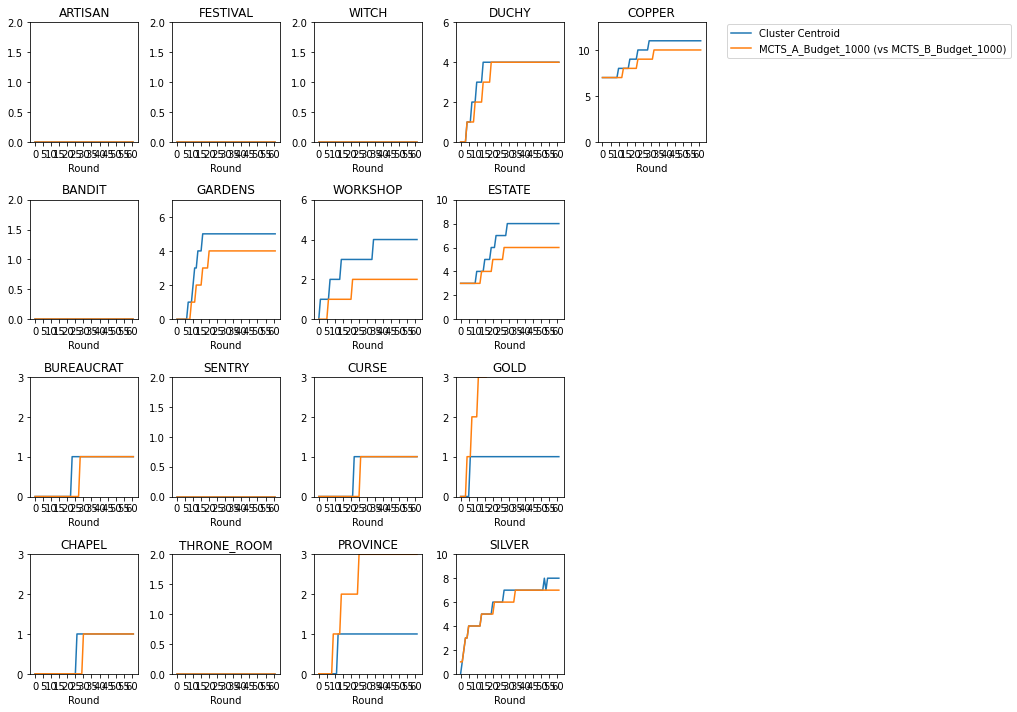

In [72]:
#compare centre with ClusterID zero to our average traces
cluster0centre = pd.DataFrame(df_cluster_centres.iloc[0]).transpose()
avg_trace_player = 'MCTS_A_Budget_1000'
avg_trace_opp = 'MCTS_B_Budget_1000'
avg_trace = average_traces[(average_traces['AgentName'] == avg_trace_player) 
                           & (average_traces['AgentNameOpponent'] == avg_trace_opp) ].drop(['AgentName','AgentNameOpponent'], axis =1)
deck_evol_comparison(cluster0centre, avg_trace, "", "_avg", card_types,maxNoOfRounds, 'Cluster Centroid', 
                     avg_trace_player + " (vs " + avg_trace_opp + ")")

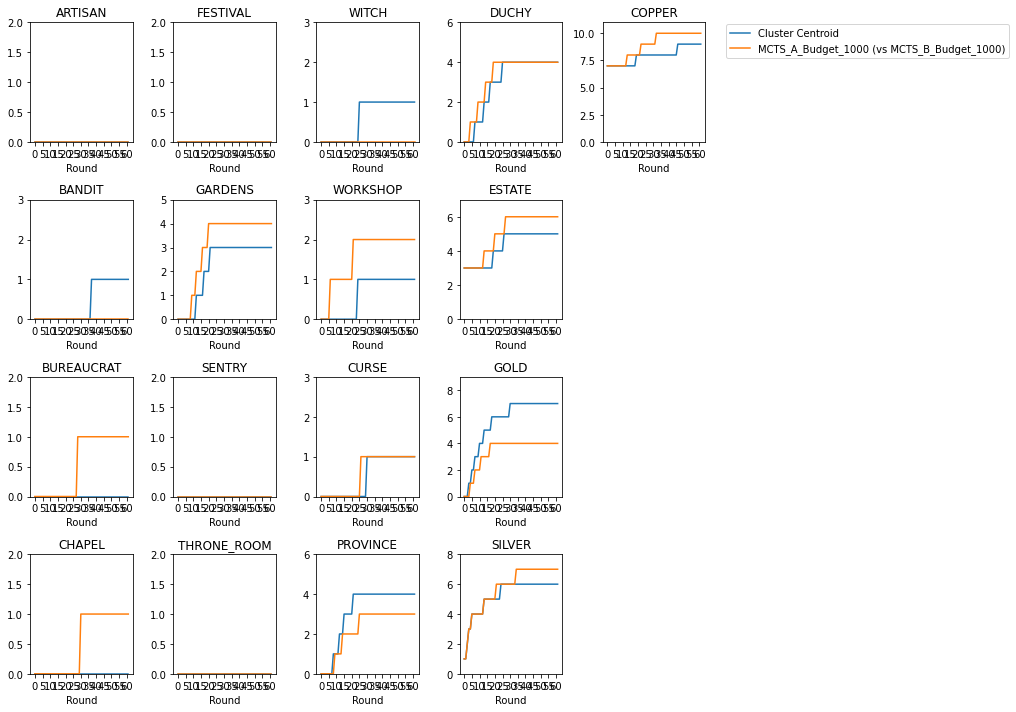

In [71]:
#compare centre with ClusterID one to our average traces
cluster1centre = pd.DataFrame(df_cluster_centres.iloc[1]).transpose()
avg_trace_player = 'MCTS_A_Budget_1000'
avg_trace_opp = 'MCTS_B_Budget_1000'
avg_trace = average_traces[(average_traces['AgentName'] == avg_trace_player) 
                           & (average_traces['AgentNameOpponent'] == avg_trace_opp) ].drop(['AgentName','AgentNameOpponent'], axis =1)
deck_evol_comparison(cluster1centre, avg_trace, "", "_avg", card_types,maxNoOfRounds, 'Cluster Centroid', 
                     avg_trace_player + " (vs " + avg_trace_opp + ")")